In [1]:
import json
import os

import boto3
from boto3 import session
from botocore.exceptions import ClientError

from dotenv import load_dotenv
load_dotenv()

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from urllib.request import urlopen
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import numpy as np

from time import ctime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)

In [4]:
# Prefix can also be created with datetime.strftime
snapshots = {}
providers = ['lime','bird']

for org in providers:
    i = 0
    if org not in snapshots:
        snapshots[org] = []
        
    for snapshot in client.list_objects_v2(
    Bucket=os.getenv("S3_BUCKET"), Prefix=org+"/2020/09/06/12", MaxKeys=1000)["Contents"]:
    # Ignore irrelevant keys
        if "samplestring" not in snapshot["Key"]:
            #print("Valid key", i)
            snapshot_obj = client.get_object(Bucket=os.getenv("S3_BUCKET"), Key=snapshot["Key"])
            snapshot_data = json.load(snapshot_obj["Body"])
            snapshots[org].append(snapshot_data)
            i+=1
    
    print(f"Loaded {len(snapshots[org])} for {org}")

Loaded 24 for lime
Loaded 36 for bird


In [5]:
def extract_time(json_obj):
    '''
    Check if a JSON object has time
    '''
    try:
        return int(json_obj['last_updated'])
    
    except KeyError:
        return 0

    
def sort_by_time(list_json):
    '''
    Sort a list of JSON objects by a certain key
    
    Inputs:
    - list_json (list): a list of JSON objects

    Returns: a sorted list
    '''
    return list_json.sort(key=extract_time)

In [6]:
for provider, data in snapshots.items():
    print("Sorting", provider, "now...")
    sort_by_time(data)

Sorting lime now...
Sorting bird now...


In [7]:
# GLOBAL VARIABLES - need to put in a config file?
zip_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/unjd-c2ca.geojson?$limit=9999999")
ca_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/igwz-8jzy.geojson?$limit=9999999")
ward_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/k9yb-bpqx.geojson")

geographies = {'zip': 
                   {'path': '../data/Boundaries - ZIP Codes.geojson', 
                    'gdf': zip_boundaries},
               'ward':
                   {'path': '../data/Boundaries - Wards (2015-).geojson',
                    'gdf': ward_boundaries},
               'community':
                   {'path': '../data/Boundaries - Community Areas (current).geojson',
                    'gdf': ca_boundaries}}

In [8]:
def map_static(df_dict, ax):
    '''
    Converts lat/lon to Point and plots Points on a map
    
    Inputs:
    - df_dict: a dictionary with pandas DataFrames, color of markers, and time
    - ax (axis object): axis to plot on
    
    Outputs: an axis object
    '''
    # Plot base layer of community areas    
    ca_boundaries.plot(facecolor="lightgrey", edgecolor="white", ax=ax)
    
    gdfs = []
    for provider in df_dict:
        
        #print("Currently working with:", provider)
        current = df_dict[provider] # This is a dictionary
        
        # Initialize new keys
        current['geo_df'] = None
        current['str_time'] = None
    
        # Create Point objects
        df = pd.DataFrame(current['df']) # CONVERT TO A DATAFRAME
        
        # Make sure lat/lon are numeric
        long = pd.to_numeric(df.lon)
        lat = pd.to_numeric(df.lat)
        
        #print("Converting lat/lon to Point objects...")
        geometry = [Point(xy) for xy in zip(long, lat)]
        df = df.drop(['lon', 'lat'], axis=1)
        
        crs = {'init': 'epsg:4326'}
    
        # Add values to new keys
        current['geo_df'] = GeoDataFrame(df, crs=crs, geometry=geometry)
        current['str_time'] = ctime(current['time'])
        
        gdfs.append(current['geo_df'])
        
        # Plot the scooters
        #print("Plotting...")
        current['geo_df'].plot(ax=ax, color=current['color'], alpha=0.5, markersize=10)

    # Format map
    ax.axis('off')
    axis_title = 'Lime: ' + df_dict['lime']['str_time'] + '        Bird: ' + df_dict['bird']['str_time']
    fig.suptitle('Location of Lime and Bird scooters', fontname='Lato', fontsize=35)
    ax.set_title(axis_title, fontdict={'fontsize':'14', 'fontweight':'1', 'fontname': 'Lato'})
    
    lime_patch = mpatches.Patch(color='lightblue', label='Lime')
    bird_patch = mpatches.Patch(color='steelblue', label='Bird')
    plt.legend(handles=[lime_patch, bird_patch], loc='lower left', prop={'family': 'Lato'})
    
    #ax.annotate('Source: TK', 
            #xy=(0.1, .08),
            #xycoords='figure fraction', 
            #horizontalalignment='left', 
            #verticalalignment='top',
            #fontsize=12, color='#555555')
       
    fig.savefig('bird_lime_locations.png')
    
    return gdfs

In [9]:
df_dict = {}

for org in providers:
    i = 0
    print("Working with...", org)
    if org not in df_dict.keys():
        df_dict[org] = {'df': None, 'color': None, 'time': None} 

    while i < len(snapshots[org]):
        if 'bikes' in snapshots[org][i]['data']:
            break
        i += 1 
        
    print("Looking at", i, "in list")
        
    df_dict[org]['df'] = snapshots[org][i]['data']['bikes']
    df_dict[org]['time'] = snapshots[org][i]['last_updated']
    
    if org == 'lime':
        df_dict[org]['color'] = 'lightblue'
    elif org == 'bird':
        df_dict[org]['color'] = 'steelblue'
        
# df_dict

Working with... lime
Looking at 1 in list
Working with... bird
Looking at 2 in list


## Step 1. Plot scooter locations

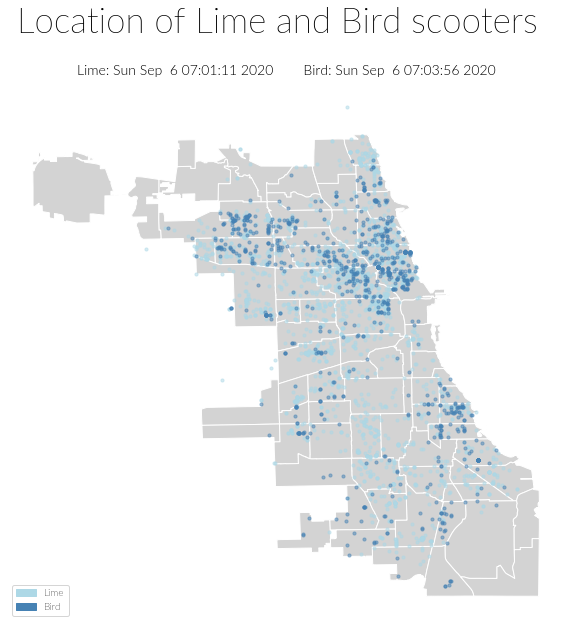

In [10]:
# Test plotting function
fig, test_ax = plt.subplots(1, figsize=(10, 10))
gdfs = map_static(df_dict, test_ax)

In [11]:
lime_scooters = gpd.GeoDataFrame(gdfs[0])
lime_scooters = lime_scooters.drop('vehicle_type', axis=1)
# print("Number of Lime scooters:", lime_scooters.shape[0])

bird_scooters = gpd.GeoDataFrame(gdfs[1])
# print("Number of Bird scooters:", bird_scooters.shape[0])

lime_scooters['provider'] = 'lime'
bird_scooters['provider'] = 'bird'

ALL_SCOOTERS = lime_scooters.append(bird_scooters)
print("Total number of scooters:", ALL_SCOOTERS.shape[0])

Total number of scooters: 2741


## Step 2. Check vendor compliance with equity priority area

In [12]:
equity_area = gpd.read_file("https://data.cityofchicago.org/resource/99tm-6k6i.geojson")
# equity_area.plot()

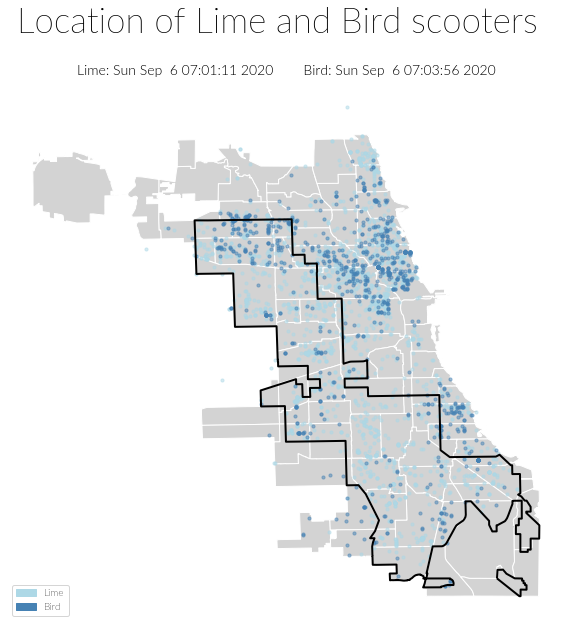

In [13]:
fig, test_ax = plt.subplots(1, figsize=(10, 10))
gdfs = map_static(df_dict, test_ax)
equity_area.plot(facecolor="none", edgecolor="black", linewidth=2, ax=test_ax)

In [14]:
# Calculate how many of the scooters from each fleet are in the shapefile
def check_compliance(gdf_point, group_col, gdf_poly):
    
    total = gdf_point.groupby(group_col).size().reset_index(name='count')
    points_within = gpd.sjoin(gdf_point, gdf_poly, how="right", op='within').groupby(group_col).size().reset_index(name='count')
    
    org_compliance = {}
    
    for group in total[group_col].values:
        pct_within = (points_within.loc[points_within[group_col] == group]['count'].values[0] / total.loc[total[group_col] == group]['count'].values[0]) * 100
        print("Is", group.capitalize(), "complying with equity zone requirement?", pct_within >= 50)
        print("Percent of", group.capitalize(), "fleet in priority equity zone:", pct_within)
        
        org_compliance[group] = pct_within
        
    return org_compliance

In [15]:
org_compliance = check_compliance(ALL_SCOOTERS, 'provider', equity_area)

Is Bird complying with equity zone requirement? False
Percent of Bird fleet in priority equity zone: 35.28064146620848
Is Lime complying with equity zone requirement? True
Percent of Lime fleet in priority equity zone: 50.107066381156315
